## EDA & Imputation

**EDA:**

1. Plots about how variables do not differ between those MSA with 11 and those without
2. Plot about geographic differences between those with 11 and those without
3. Plots of murder vs Census
4. Plot of top 10 murder by MSA and by State 
5. Trend of Year and Murder

**Imputation**

The imputation needs of Puerto Rico were going to be too great, so we decided to restrict our focus to just the continental United States.

Detailed Imputation Strategies are already in the notebook. Make sure that we emphasize that we used linear interpolation within MSA


After applying imputation strategy, the only numeric variables that were still missing were the crime variables within the largest city of the Carson City MSA and the unemployment data for Carson City MSA.  We looked up the Carson City MSA and found out that the entire MSA is primarily Carson City. As a result, we just used the MSA-wide crime data for the city wide data as well.

For the unemployment variables, we looked up the annual unemployment rate for Carson City and just used this.


In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
%matplotlib inline

# of MSA's: 392


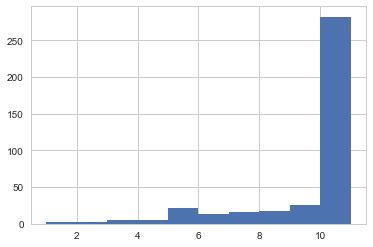

In [2]:
# Load in final dataframe without imputed values
final_df = pd.read_json("output/final.json")

print("# of MSA's: %i" %len(final_df['join_key'].unique()))
final_df['num_years'] = final_df.groupby('join_key')['year'].transform(len)
groups = final_df.loc[:, ['join_key', 'num_years']].drop_duplicates()
plt.hist(groups['num_years'])
# Fow now we are taking those that have all years
full_msa = final_df.num_years == 11

In [3]:
# Quick to look at differences between full MSA and non
def compare_msa(var, ax, max_value):
    ax.hist(final_df.loc[full_msa, var], range=(0, max_value), alpha=0.5, label='11')
    ax.hist(final_df.loc[~full_msa, var], range=(0, max_value), alpha=0.5, label='<11')
    ax.set_title("%s Histogram" %var)
    ax.legend();

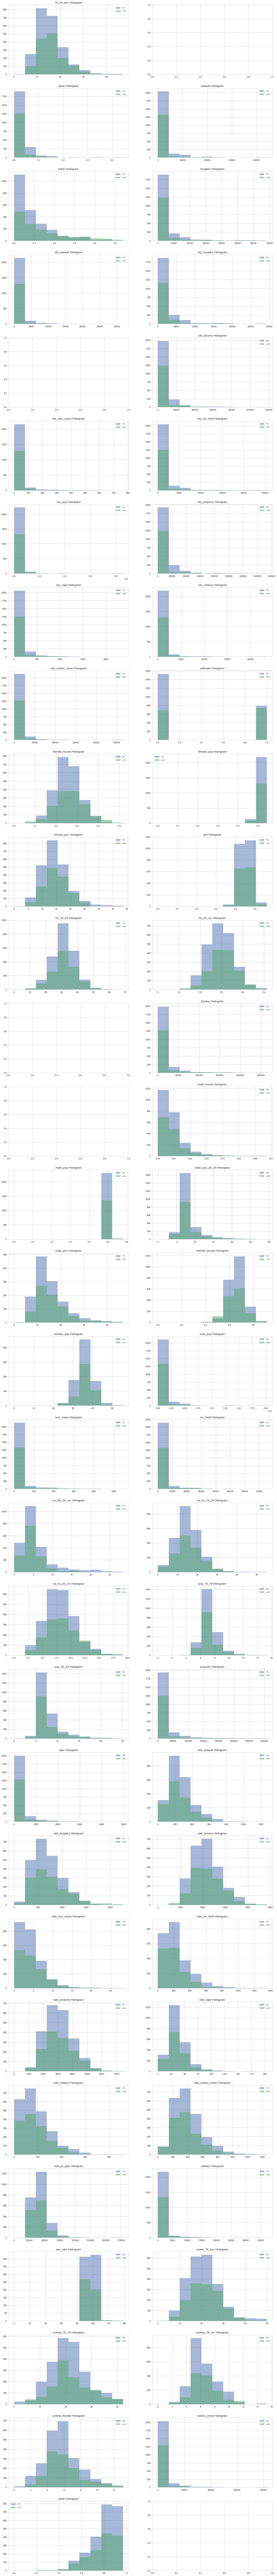

In [4]:
# Look at Differences for MSA that have all years and ones that do not
fig, ax = plt.subplots(31,2, figsize=(20,200))
ax = ax.flatten()
graph_vars = [v for v in final_df.columns 
              if "state_" not in v and "MSA_" not in v and 'year' not in v]
for i, v in enumerate(graph_vars):
    if v not in ['city_key', 'MSA', 'state_key', 'join_key', 'largest_city']:
        compare_msa(v, ax[i], final_df.loc[:, v].max())

### Examining Differences in States between MSA with full years and non-years

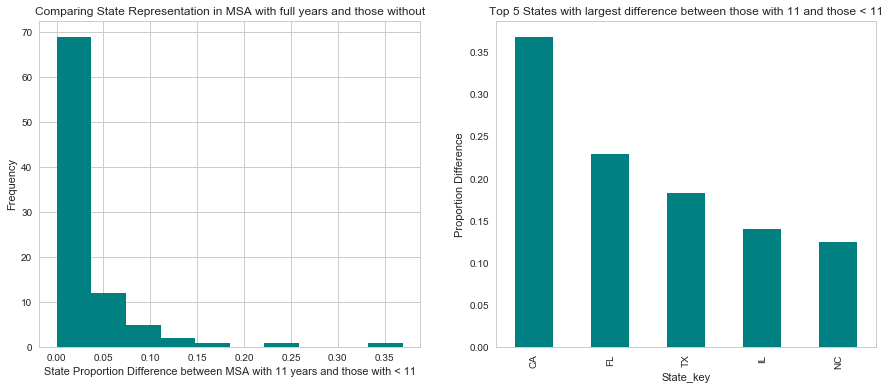

In [5]:
# Look at Differences by states
msa_11 =  final_df.loc[full_msa, ['city_key', 'state_key']].drop_duplicates()
msa_11_counts = msa_11.state_key.value_counts()
msa_11_pct  = pd.DataFrame(msa_11_counts / len(msa_11_counts))
msa_11_pct = msa_11_pct.rename(index=str, columns={'state_key': 'prop_11'})

msa_lt_11 =  final_df.loc[~full_msa, ['city_key', 'state_key']].drop_duplicates()
msa_lt_11_counts = msa_lt_11.state_key.value_counts()
msa_lt_pct = pd.DataFrame(msa_lt_11_counts / len(msa_lt_11_counts))
msa_lt_pct = msa_lt_pct.rename(index=str, columns={'state_key': 'prop_lt_11'})

compare = msa_11_pct.join(msa_lt_pct, how='outer')
compare.loc[compare.prop_11.isnull(), 'prop_11'] = 0
compare.loc[compare.prop_lt_11.isnull(), 'prop_lt_11'] = 0
compare['diff'] = abs(compare['prop_11'] - compare['prop_lt_11'])
fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].set_xlabel("State Proportion Difference between MSA with 11 years and those with < 11")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Comparing State Representation in MSA with full years and those without")
ax[0].hist(compare['diff'], color='teal');

ax[1].set_xlabel("State_key")
ax[1].set_ylabel("Proportion Difference")
ax[1].set_title("Top 5 States with largest difference between those with 11 and those < 11")
ax[1] = compare.sort_values("diff", ascending=False).iloc[0:5, 2].plot(kind='bar', color='teal', grid=False)
#compare.head(100)

Based on the above plots there is no clear sytematic difference between those that have 11 and those that do not. Because our rolling window cross validation needs lots of years, we are going to keep the dataframes that have all 11 years

In [6]:
final_df = final_df.loc[full_msa, :]
del final_df['num_years']
print(final_df.shape)
final_df.to_json('output/final_only11.json')

(2321, 555)


In [7]:
"""
Function
-------
x_y_scatter

This function plots a scatter plot between two variables with
certain stylings
"""
def x_y_scatter(x_var, y_var, x_label, y_label, title, ax):
    ax.scatter(x_var, y_var, color='teal', alpha=0.5)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel(y_label, fontsize=14);

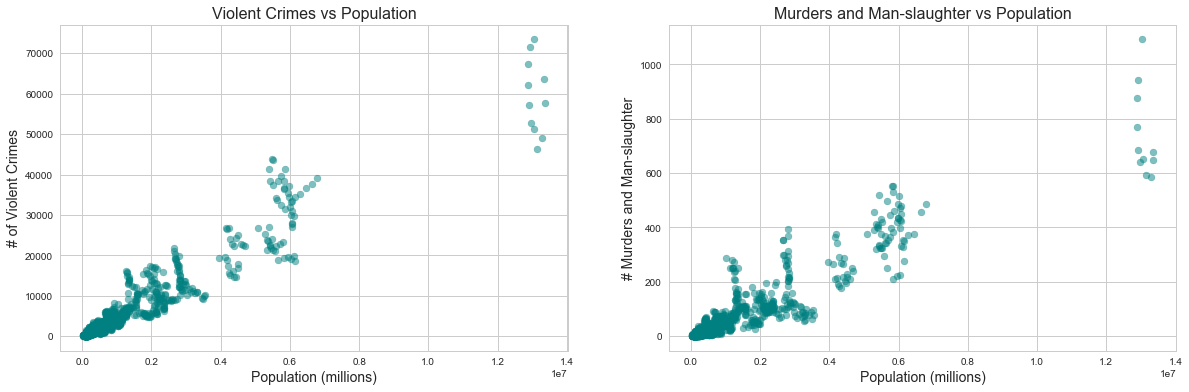

In [8]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
x_y_scatter(final_df['msa_pop'],
           final_df['violent_crime'],
           x_label='Population (millions)',
           y_label='# of Violent Crimes',
           title='Violent Crimes vs Population',
           ax=ax[0])
x_y_scatter(final_df['msa_pop'],
           final_df['mur_mans'],
           x_label='Population (millions)',
           y_label='# Murders and Man-slaughter',
           title='Murders and Man-slaughter vs Population',
           ax=ax[1])

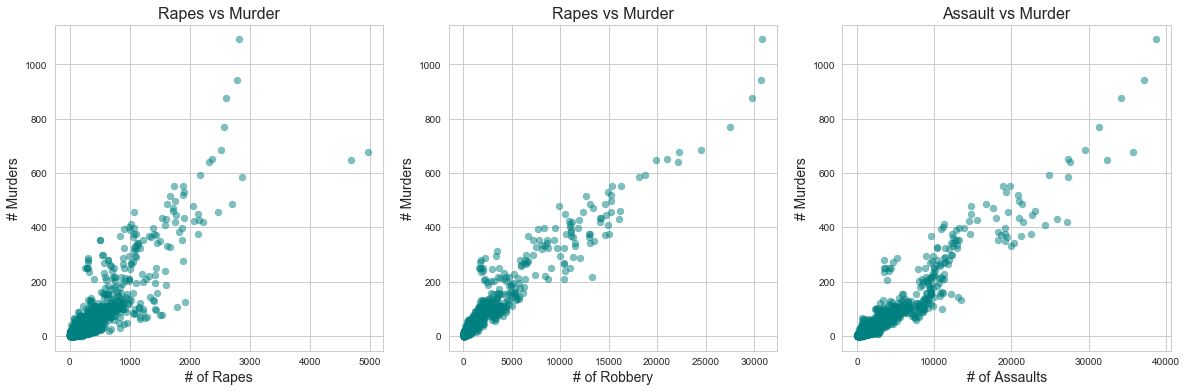

In [9]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1,3,figsize=(20,6))

# Rape
x_y_scatter(final_df['rape'],
           final_df['mur_mans'],
           x_label='# of Rapes',
           y_label='# Murders',
           title='Rapes vs Murder',
           ax=ax[0])

# Robbery
x_y_scatter(final_df['robbery'],
           final_df['mur_mans'],
           x_label='# of Robbery',
           y_label='# Murders',
           title='Rapes vs Murder',
           ax=ax[1])
# Assault
x_y_scatter(final_df['assault'],
           final_df['mur_mans'],
           x_label='# of Assaults',
           y_label='# Murders',
           title='Assault vs Murder',
           ax=ax[2])

label_size = 13
matplotlib.rcParams['xtick.labelsize'] = label_size
plt.savefig('Murder Other crimes', bbox_inches='tight')

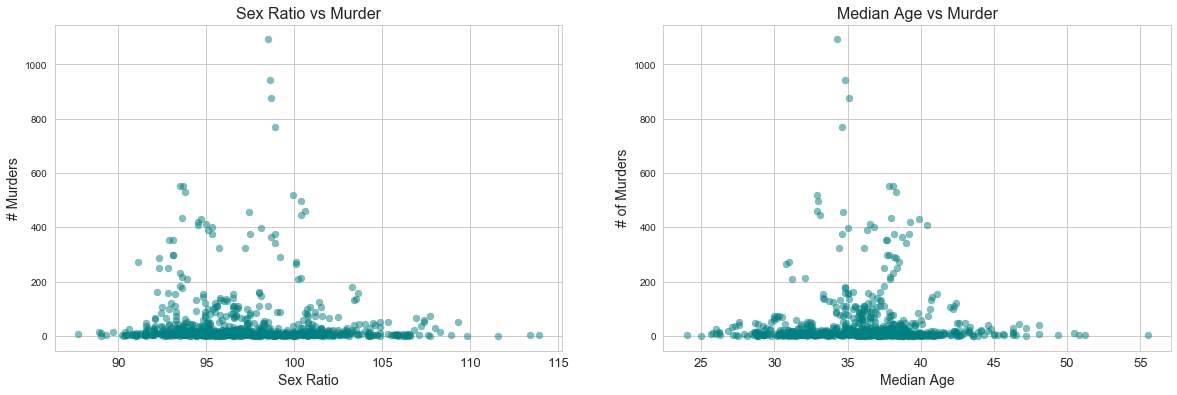

In [10]:
fig, ax = plt.subplots(1,2,figsize=(20,6))
x_y_scatter(final_df['sex_ratio'],
           final_df['mur_mans'],
           x_label='Sex Ratio',
           y_label='# Murders',
           title='Sex Ratio vs Murder',
           ax=ax[0])
x_y_scatter(final_df['median_age'],
           final_df['mur_mans'],
           x_label='Median Age',
           y_label='# of Murders',
           title='Median Age vs Murder',
           ax=ax[1])

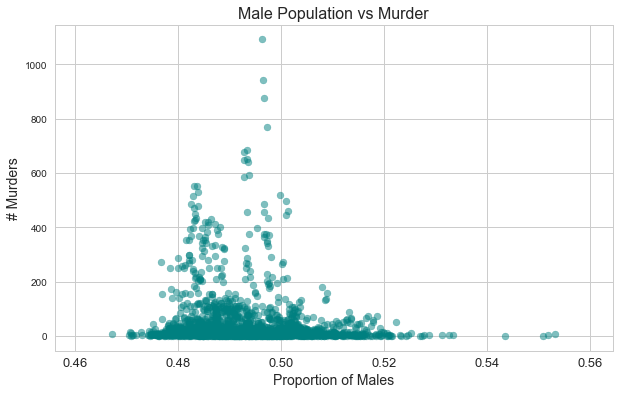

In [11]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
x_y_scatter(final_df['male_pop'],
           final_df['mur_mans'],
           x_label='Proportion of Males',
           y_label='# Murders',
           title='Male Population vs Murder',
           ax=ax)

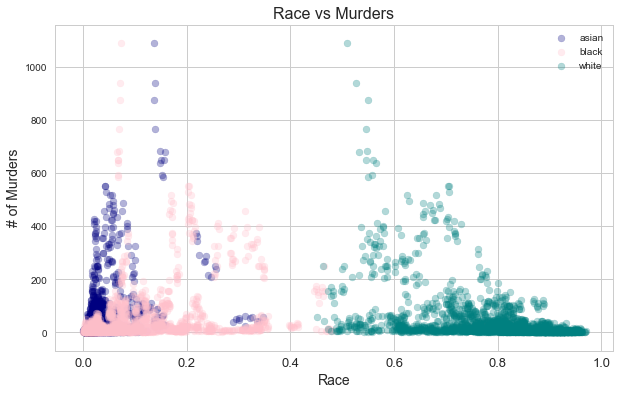

In [12]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(final_df['asian'], final_df['mur_mans'], color='navy', alpha=0.3, label='asian')
ax.scatter(final_df['black'], final_df['mur_mans'], color='pink', alpha=0.3, label='black')
ax.scatter(final_df['white'], final_df['mur_mans'], color='teal', alpha=0.3, label='white')
ax.set_title('Race vs Murders', fontsize=16)
ax.set_xlabel('Race', fontsize=14)
ax.set_ylabel('# of Murders', fontsize=14)
ax.legend();

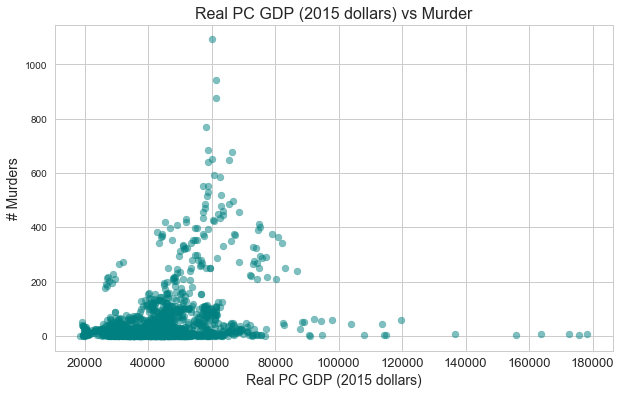

In [13]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
x_y_scatter(final_df['real_pc_gdp'],
           final_df['mur_mans'],
           x_label='Real PC GDP (2015 dollars)',
           y_label='# Murders',
           title='Real PC GDP (2015 dollars) vs Murder',
           ax=ax)

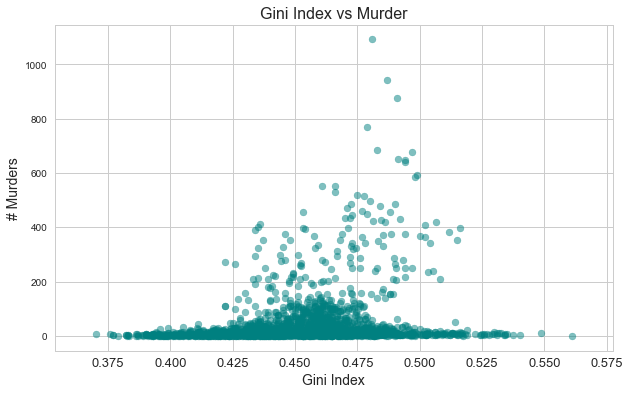

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
x_y_scatter(final_df['gini'],
           final_df['mur_mans'],
           x_label='Gini Index',
           y_label='# Murders',
           title='Gini Index vs Murder',
           ax=ax)
#ax.set_ylim(100,1100);

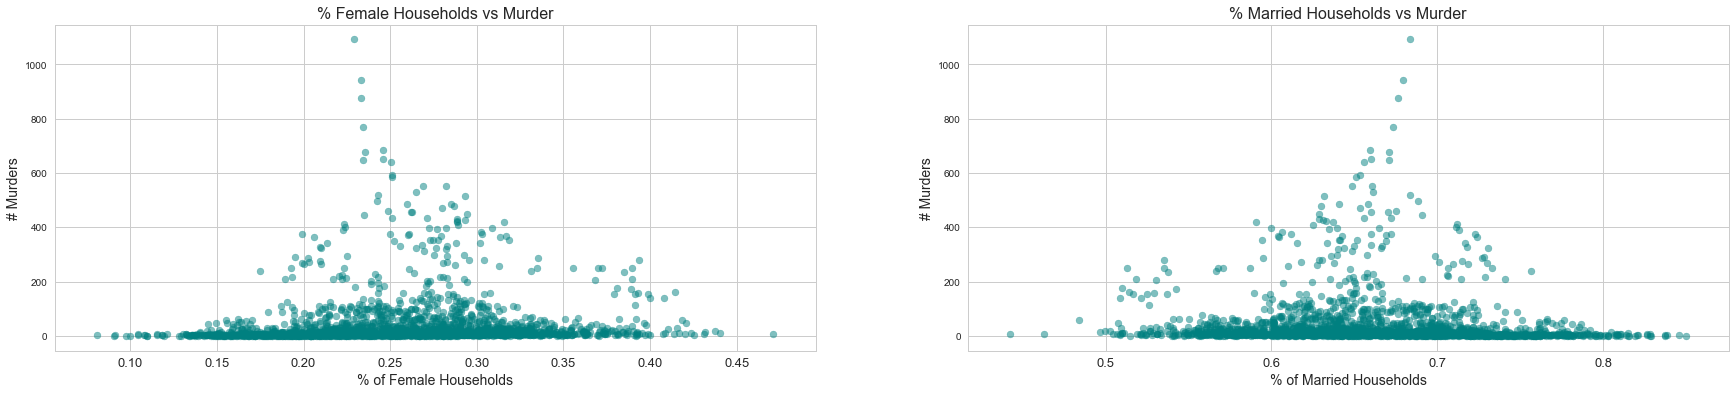

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(30,6))
x_y_scatter(final_df['female_house'],
           final_df['mur_mans'],
           x_label='% of Female Households',
           y_label='# Murders',
           title='% Female Households vs Murder',
           ax=ax[0])

x_y_scatter(final_df['married_house'],
           final_df['mur_mans'],
           x_label='% of Married Households',
           y_label='# Murders',
           title='% Married Households vs Murder',
           ax=ax[1])

In [16]:
'''
Function
----------
scatter_list_murder

This function takes a list of variables and plots each one vs murder

Parameter list:
    var_list - list of strings to plot
    nrows - # of rows in the grid
    ncols - # of cols in grid
    figsize- tuple for figsize

'''
def scatter_list_murder(var_list, nrows, ncols, figsize, log_trans=False):
    fig, ax = plt.subplots(nrows,ncols,figsize=figsize)
    ax = ax.flatten()
    for i, v in enumerate(var_list):
        if log_trans:
            var = np.log(final_df[v])
            label= "Log(" + v + ")"
        else:
            var = final_df[v]
            label = v
            
        
        x_y_scatter(var,
               final_df['mur_mans'],
               x_label=label,
               y_label='# Murders',
               title='%s vs Murder' %v,
               ax=ax[i])
    fig.tight_layout();

### Unemployment Rate

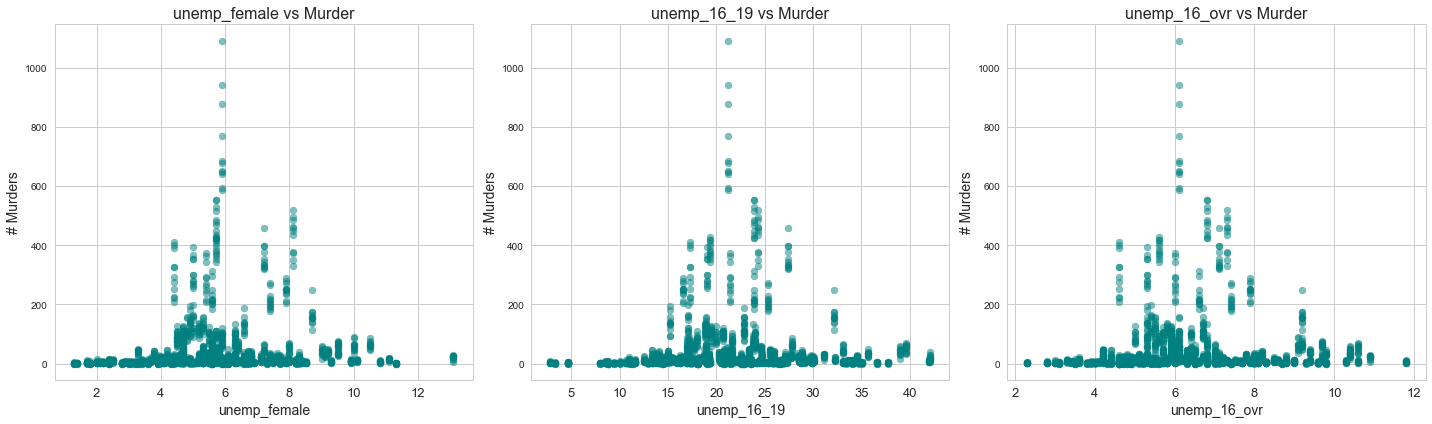

In [17]:
### Unemployment Rate
scatter_list_murder(['unemp_female', 'unemp_16_19', 'unemp_16_ovr'],
                    1,3, (20,6))

### Education

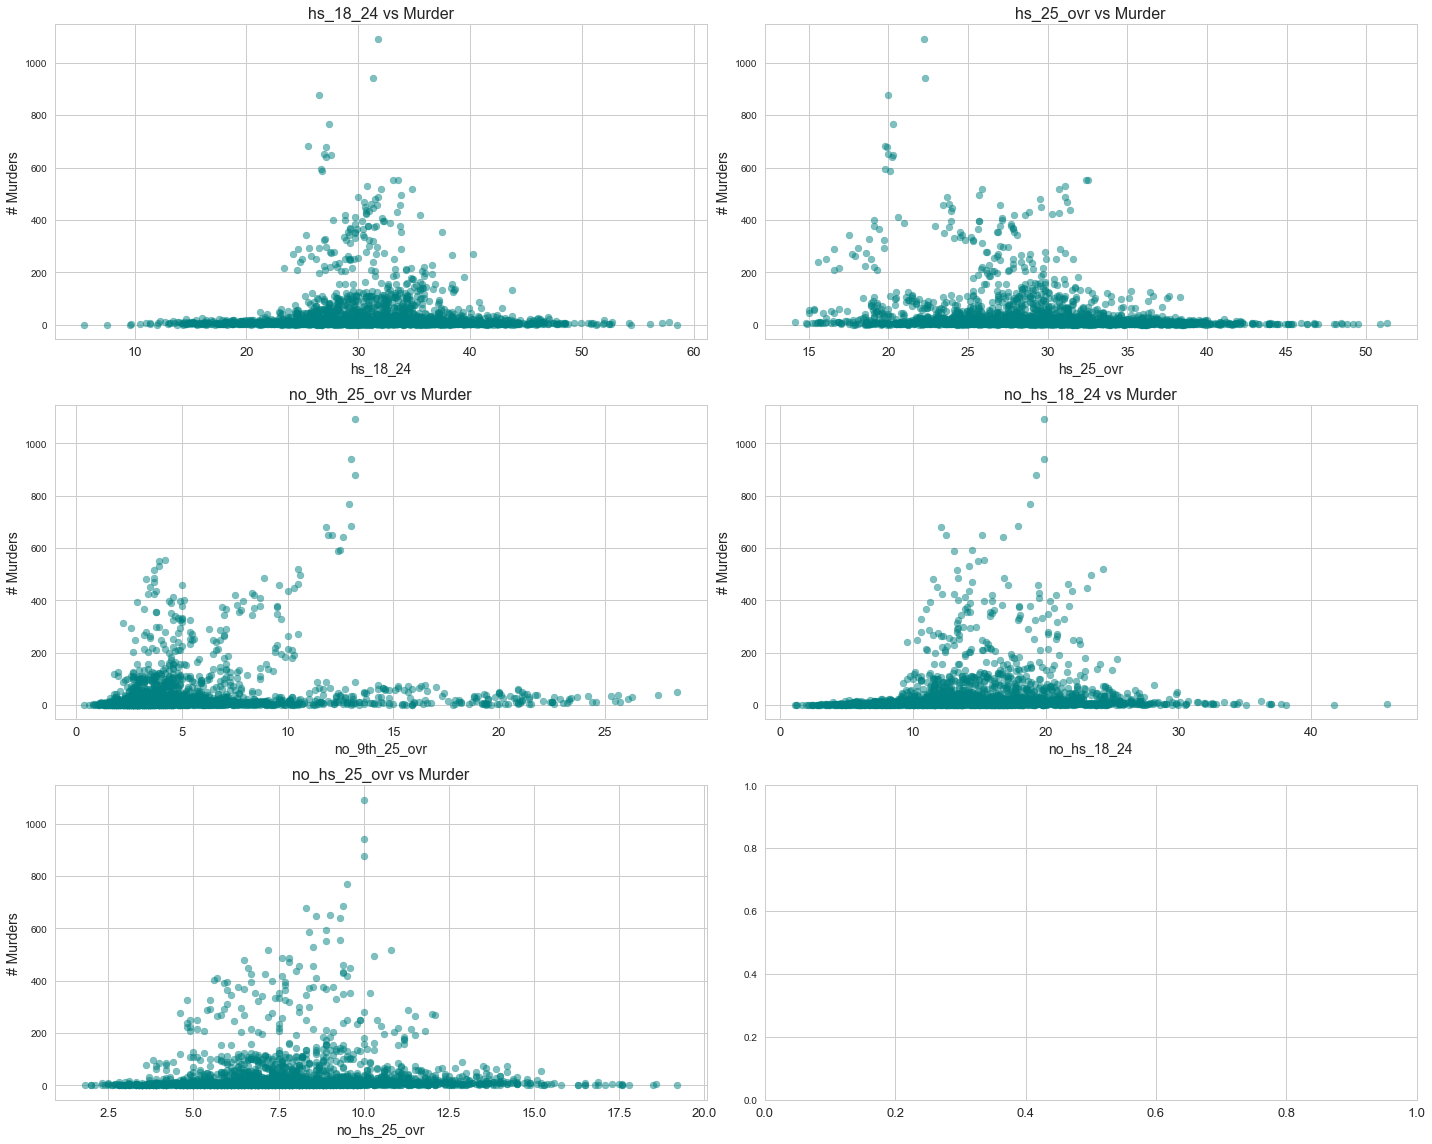

In [18]:
scatter_list_murder(['hs_18_24', 'hs_25_ovr', 'no_9th_25_ovr', 
                     'no_hs_18_24', 'no_hs_25_ovr'],
                    3, 2, (20, 16))

### Poverty

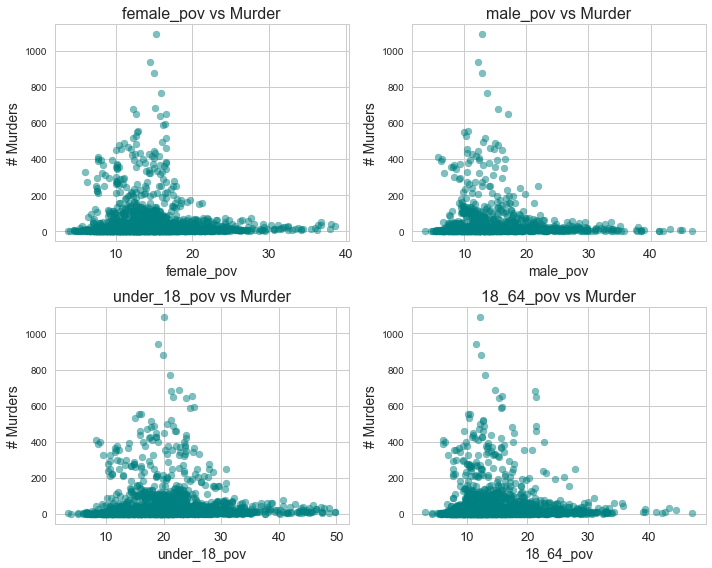

In [19]:
scatter_list_murder(['female_pov', 'male_pov', 'under_18_pov', '18_64_pov'],
                    2, 2, (10, 8), log_trans=False)

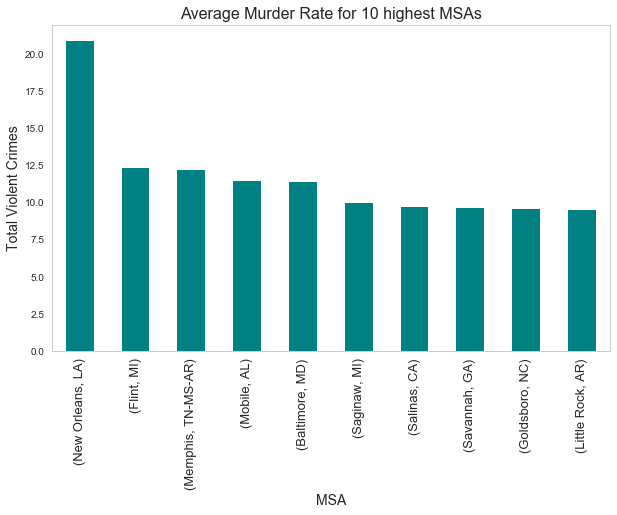

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax = final_df.groupby(['city_key', 'state_key'])['rate_mur_mans'].mean().sort_values(
    ascending=False).iloc[0:10].plot(kind='bar', color='teal', grid=False)
ax.set_title('Average Murder Rate for 10 highest MSAs', fontsize=16)
ax.set_xlabel('MSA', fontsize=14)
ax.set_ylabel('Total Violent Crimes',fontsize=14);

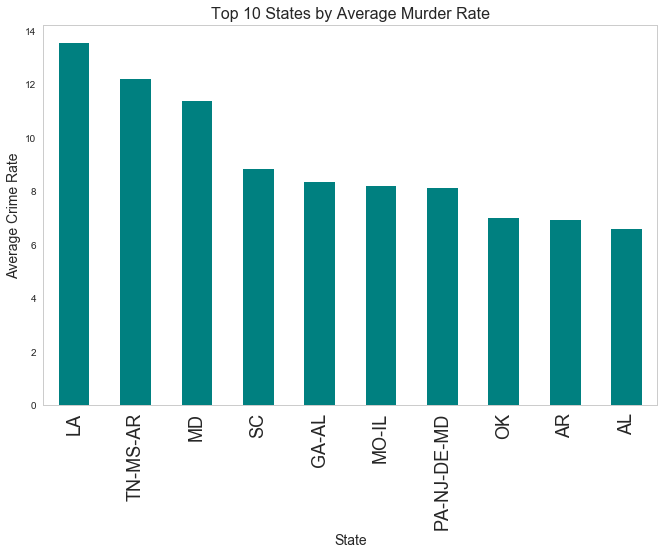

In [21]:
label_size = 18
matplotlib.rcParams['xtick.labelsize'] = label_size 
fig, ax = plt.subplots(1,1, figsize=(11,7))
ax=final_df.groupby('state_key')['rate_mur_mans'].mean().sort_values(
    ascending=False).iloc[0:10].plot(kind='bar',grid=False, color='teal')
ax.set_title('Top 10 States by Average Murder Rate', fontsize=16)
ax.set_xlabel('State', fontsize=14)
ax.set_ylabel('Average Crime Rate',fontsize=14)
plt.savefig('State_vs_Avg_Crime_rate', bbox_inches='tight')

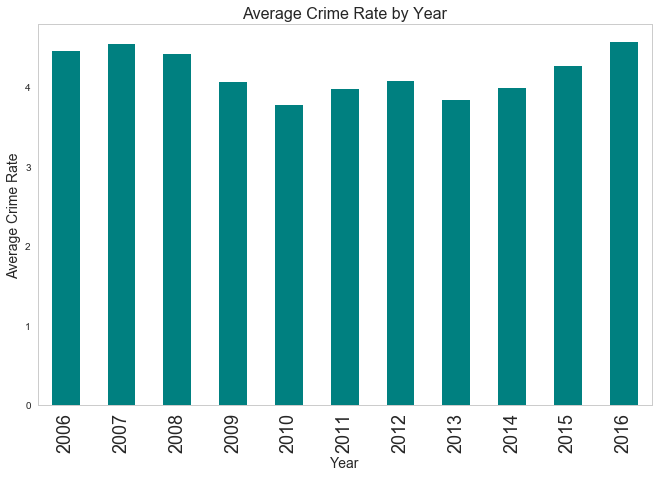

In [22]:
fig, ax = plt.subplots(1,1, figsize=(11,7))
ax=final_df.sort_values("year").groupby('year')['rate_mur_mans'].mean().plot(kind='bar',grid=False, color='teal')
ax.set_title('Average Crime Rate by Year', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Average Crime Rate',fontsize=14);